In [1]:
# test pipeline for the bruyere dataset
from fn_cfg import *
import params as cfg

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


version
stimulusType
eegHeadsetID
computerInfo
contextualInfo
scanDetails
impedances
stimSequence
context
channels
startTime
endTime
1.1.1
['/Users/joshuaighalo/Downloads/raw/0_1_12072018_1206/0_1_12072018_1206.bin']
channel P07 utilized
channel 0Z utilized
data contains Fz, Cz, Pz & two EOG channels


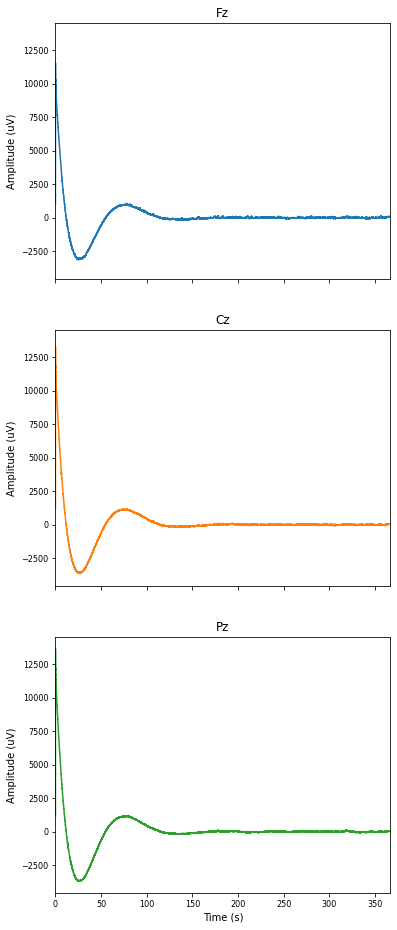

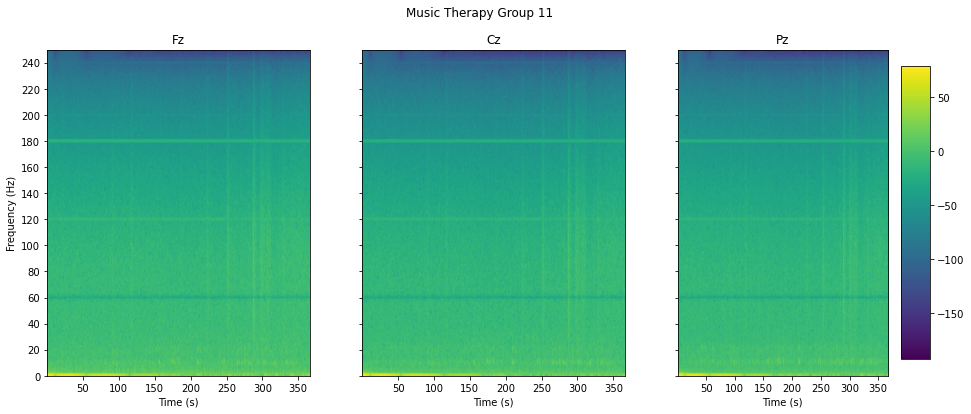

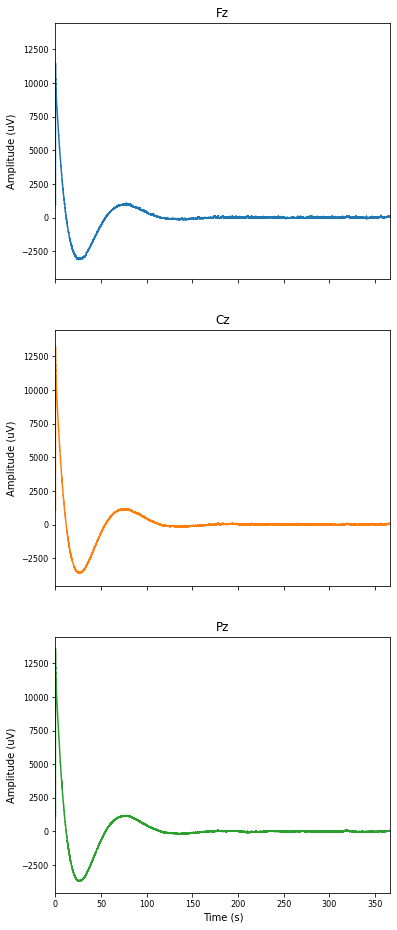

In [2]:
#localPath = '/Volumes/Backup Plus/EEG_Datasets/laurel_place/dataset'
#filename = '0002_2_12122019_1225'
#version = 1.0

version = 1.1
filename = '0_1_12072018_1206'
localPath = '/Users/joshuaighalo/Downloads/raw'

device = importFile.neurocatch()
fileObjects = device.init(version,filename,localPath)
rawEEG = fileObjects[0]
rawEOG = fileObjects[1]
rawEEGEOG = fileObjects[2]
time = fileObjects[3]
trigOutput = fileObjects[4]
plots(time,rawEEG,titles=cfg.channelNames,figsize=cfg.figure_size,pltclr=cfg.plot_color)
spectogramPlot(rawEEG,fs,nfft=cfg.nfft,nOverlap=cfg.noverlap,figsize=(16,6),subTitles=cfg.channelNames,title='Music Therapy Group 11')
filtering = filters()
notchFilterOutput = filtering.notch(rawEEG,line,fs)
plots(time,notchFilterOutput,titles=cfg.channelNames,figsize=cfg.figure_size,pltclr=cfg.plot_color)
#spectogramPlot(notchFilterOutput,fs,nfft=cfg.nfft,nOverlap=cfg.noverlap,figsize=(16,6),subTitles=cfg.channelNames,title='Music Therapy Group 11')


In [11]:
" Functions Utilized"

#   Comparative Study of Wavelet-Based Unsupervised Ocular Artifact Removal Techniques for Single-Channel EEG Data
#   Signal to Artifact Ratio (SAR) is a quantification method to measure the amount of artifact removal 
#   in a specific signal after processing with an algorithm [40].
#   SAR is a measure of the amount of artifact removal in a signal.
#   x = EEG signal containing artifact
#   y = EEG signal obtained after running an artifact free algorithm
def sar(x,y):
    return 10*np.log10((np.std(x))/(np.std(x-y)))
def mse(x,y):
    return math.sqrt(np.square(np.subtract(x,y)).mean())

def DWT(data):
    #   Probability Mapping Based Artifact Detection and Wavelet Denoising based 
    #   Artifact Removal from Scalp EEG for BCI Applications
    #  Perform DWT on the data
    #   Input: data - EEG data: 1D array (samples x channel)
    #   Output: new signal: (samples x number of wavelets)
    #           signal_global - new signal extracted after global threshold 
    #           signal_std - new signal extracted after std threshold 
    #   Reference:  choice of number of levels to threshold gotten from "Comparative Study of Wavelet-Based Unsupervised 
    #               Ocular Artifact Removal Techniques for Single-Channel EEG Data"
      
    wavelets = ['sym3','coif3','haar','bior4.4'] 
    def dwt_only(data,wavelet):
        def dwt(data,wavelet):
            coeffs = wavedec(data,wavelet,level=10)
            return np.array(coeffs,dtype=object).T

        def global_threshold(data,coeffs):
            def coeffs_approx(data,coeffs):
                return (np.median(abs(coeffs[0]))/0.6745)*(np.sqrt(2*np.log(len(data))))
            def coeffs_detail(data,coeffs):
                return (np.median(abs(coeffs[1]))/0.6745)*(np.sqrt(2*np.log(len(data))))
            arr_approx = coeffs_approx(data,coeffs)
            arr_detail = coeffs_detail(data,coeffs)
            return np.vstack((arr_approx,arr_detail))

        def apply_threshold(coeffs,threshold):
            def apply_threshold_approx(coeffs,threshold):
                coeffs[0][abs(coeffs[0])>threshold[0]] = 0
                coeffs_approx = coeffs[0]
                return coeffs_approx
            def apply_threshold_detail(coeffs,threshold):
                coeffs = coeffs[1:len(coeffs)]
                #coeffs[0][abs(coeffs[0])>threshold[1]] = 0
                #coeffs[1][abs(coeffs[1])>threshold[1]] = 0
                coeffs[2][abs(coeffs[2])>threshold[1]] = 0  # level 8
                coeffs[3][abs(coeffs[3])>threshold[1]] = 0  # level 7
                coeffs[4][abs(coeffs[4])>threshold[1]] = 0  # level 6
                coeffs[5][abs(coeffs[5])>threshold[1]] = 0  # level 5
                coeffs[6][abs(coeffs[6])>threshold[1]] = 0  # level 4
                coeffs[7][abs(coeffs[7])>threshold[1]] = 0  # level 3
                #coeffs[8][abs(coeffs[8])>threshold[1]] = 0
                #coeffs[9][abs(coeffs[9])>threshold[1]] = 0
                return coeffs
            arr_approx = apply_threshold_approx(coeffs,threshold)
            arr_detail = apply_threshold_detail(coeffs,threshold)
            arr_detail = list(np.array(arr_detail).T)
            arr_approx = arr_approx
            coefs = arr_detail
            (coefs).insert(0,arr_approx)
            return coefs

        def inv_dwt(coeffs,wavelet):
            def inverse_dwt(coeffs,wavelet):
                return waverec(coeffs,wavelet)
            arr = (inverse_dwt(list(np.array(coeffs,dtype=object)),wavelet))
            return  (np.array(arr).T)[:-1]

        coeffs = dwt(data,wavelet)
        threshold_global = global_threshold(data,coeffs)
        coeffs_global = apply_threshold(coeffs,threshold_global)
        signal_global = inv_dwt(coeffs_global,wavelet)
        return signal_global

    newEEG_global = []
    for i in range(len(wavelets)):
        newEEG_global.append((dwt_only(data,wavelets[i])))
    newEEG_global = np.array(newEEG_global).T
    return newEEG_global

SAR sym3 for global threshold:  0.074
SAR coif3 for global threshold:  0.019
SAR haar for global threshold:  0.019
SAR bior4.4 for global threshold:  0.055
MSE sym3 for global threshold:  1369.634
MSE coif3 for global threshold:  1387.157
MSE haar for global threshold:  1387.203
MSE bior4.4 for global threshold:  1375.768


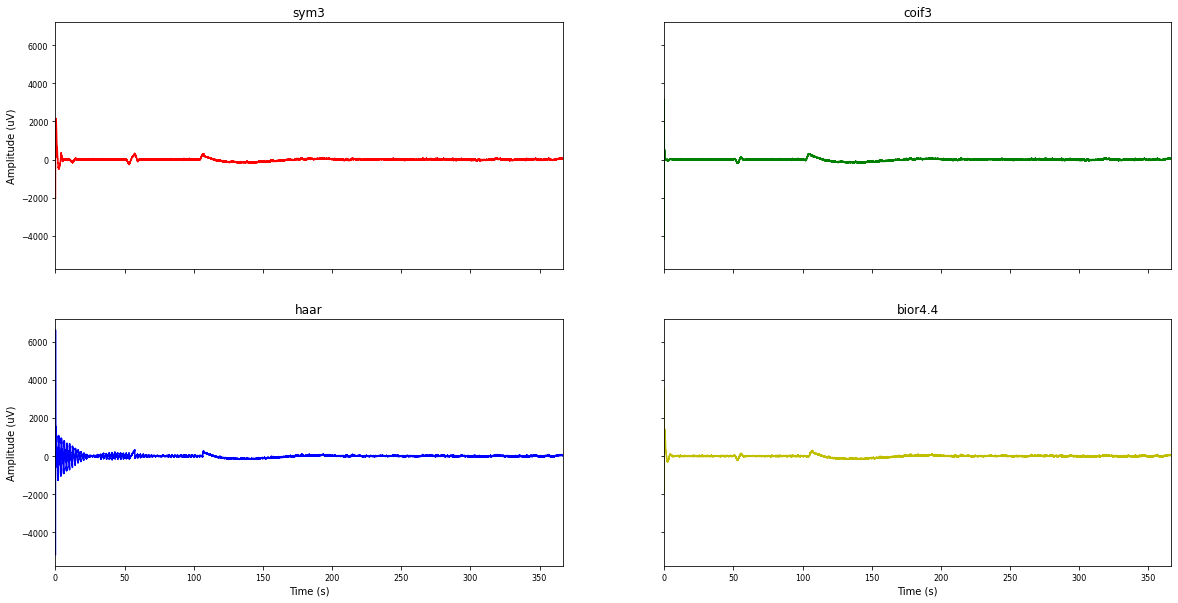

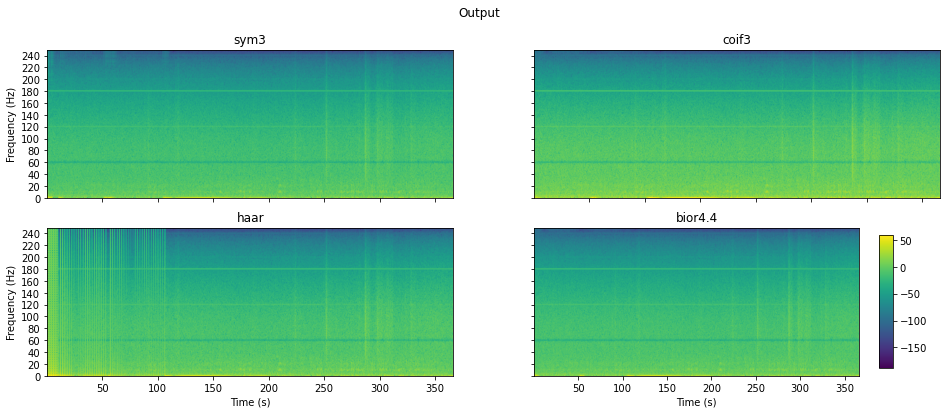

In [12]:
"DWT only"
data = notchFilterOutput[:,1]
dwt_eeg_gt = DWT(data)
plots(time,dwt_eeg_gt,['sym3','coif3','haar','bior4.4'],(20,10),['r','g','b','y'])

print("SAR sym3 for global threshold: ", round(sar(data,dwt_eeg_gt[:,0]),3))
print("SAR coif3 for global threshold: ", round(sar(data,dwt_eeg_gt[:,1]),3))
print("SAR haar for global threshold: ", round(sar(data,dwt_eeg_gt[:,2]),3))
print("SAR bior4.4 for global threshold: ", round(sar(data,dwt_eeg_gt[:,3]),3))
print("MSE sym3 for global threshold: ", round(mse(data,dwt_eeg_gt[:,0]),3))
print("MSE coif3 for global threshold: ", round(mse(data,dwt_eeg_gt[:,1]),3))
print("MSE haar for global threshold: ", round(mse(data,dwt_eeg_gt[:,2]),3))
print("MSE bior4.4 for global threshold: ", round(mse(data,dwt_eeg_gt[:,3]),3))

spectogramPlot(dwt_eeg_gt,fs,nfft=cfg.nfft,nOverlap=cfg.noverlap,figsize=(16,6),subTitles=['sym3','coif3','haar','bior4.4'],title='Output')

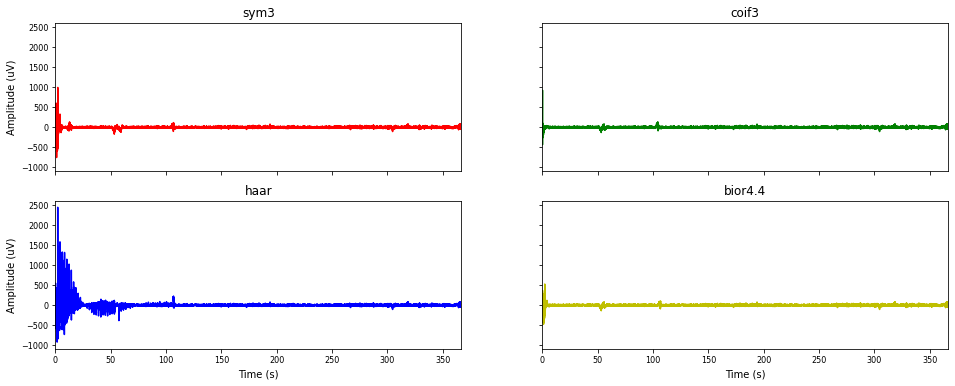

In [22]:
"DWT + Adaptive filter"
adaptiveFilterOutput = filtering.adaptive(dwt_eeg_gt,rawEOG)
plots(time,adaptiveFilterOutput,titles=['sym3','coif3','haar','bior4.4'],figsize=(16,6),pltclr=['r','g','b','y'])